In [ ]:
# Copyright 2016-present, Facebook, Inc.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE-examples file in the root directory of this source tree.

# ML Assisted Sampling:  Finding the prevalence of an infrequent class

When sampling, sometimes we have extra information about the 'class' we would like to measure. In these cases we can use this information to take a more accurate sample.

For example, when fighting spam, one question that is useful to answer is what the overall prevalence of spam is within the ecosystem. If we are lucky, the overall percent of spam is small. This poses some interesting challenges:
* The number of spam samples may be small, if we are reviewing these items manually then we spend most of our time reviewing good items (wasted effort).
* We may rely on the spam samples to learn from and make decisions about how to best prioritize
* The variance associated with the sampling method is large relative to the estimated %. Reducing the error bars associated with the sample is important!

We will find that ML Sampling allows us to reduce the error of the sample while increasing the number of positive examples.

In this example, we are going to use the Covertype dataset as it is publicly accessible and suitable enough for our use case. We are going to code one of the classes in the dataset as 'spam'.
1. We train a model to predict 'spam'
1. We will use the classifier to take a ML Sample on the test data
1. We will show how Model Assisted Sampling produces a good estimation of the overall prevalence of spam and that it prioritizes sampling of items that are more likely to be 'spam' 
1. Finally, we will compare ML Sampling to with regular random sampling to show the error associated with ML Sampling is less

In [1]:
import numpy as np
import pandas as pd

import ml_sampler
import tutorial_helpers

In [2]:
# https://archive.ics.uci.edu/ml/datasets/Covertype
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
# !gunzip covtype.data.gz
data = pd.read_csv('covtype.data', names=range(54)+['class'])

In [3]:
data['class'].value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: class, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split

# lets use class == 5 as the 'spam' - totally made up but serves as a decent example
X, y = data[data.columns - ['class']], data['class'] == 5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=42)

In [5]:
# for training purposes we want 50% 'spam' and 50% 'ham'
num_train = len(y_train)
num_pos = y_train.sum()
samp_prob = num_pos * 1.0 / num_train

train_sel = [True if y else np.random.rand() < samp_prob for y in y_train]

In [6]:
from sklearn import linear_model
clf = linear_model.LogisticRegression(C=1)
clf.fit(X_train[train_sel], y_train[train_sel])

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [7]:
# number of times the content was viewed 
views = np.random.exponential(scale=100, size=len(y_test))

# is spam?
is_spam = y_test.values 

# spam classifier scores
scores = clf.predict_proba(X_test)[:,1]

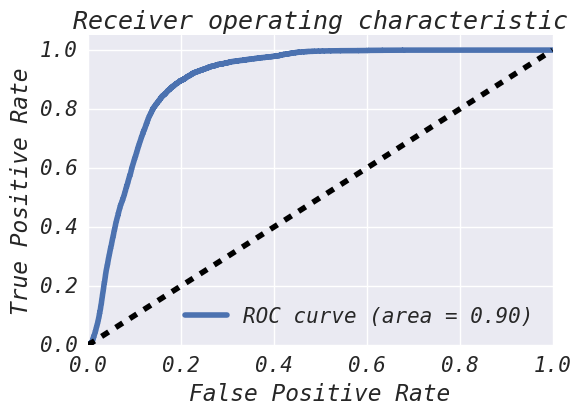

In [8]:
# a decent classifier
tutorial_helpers.plot_roc(is_spam, scores)

In [9]:
# % of spam in the dataset, this is an important number to remember
pcnt_spam = views[is_spam].sum() * 100.0 / views.sum()
pcnt_spam

1.649652153938755

In [10]:
# create a few bins to bucket scores by. the ml_sampler will attempt to sample roughly evenly 
# from each bin.
bins = np.linspace(0,1,8)

# index - index entries corresponding to the items that were sampled
# weights - associated weights with the records returned
sample_index, sample_weights = ml_sampler.biased_sample( 
    biases=ml_sampler.interpolated_pdf_reciprocal(scores, bins=bins),  
    weights=views,
    num_samples=1000
)

In [11]:
# we sampled more things that were 'spam' as judged by our classifier
is_spam[sample_index].mean() * 100.0

4.1000000000000005

In [12]:
# actually, we get several times more positive examples than normal random sampling.
is_spam[sample_index].mean() / is_spam.mean()

2.4888611727830745

In [13]:
# our estimate of the % of spam 
sample_weights[is_spam[sample_index]].sum() / views.sum() * 100.0

1.6828446464282221

In [14]:
# true % of spam
pcnt_spam

1.649652153938755

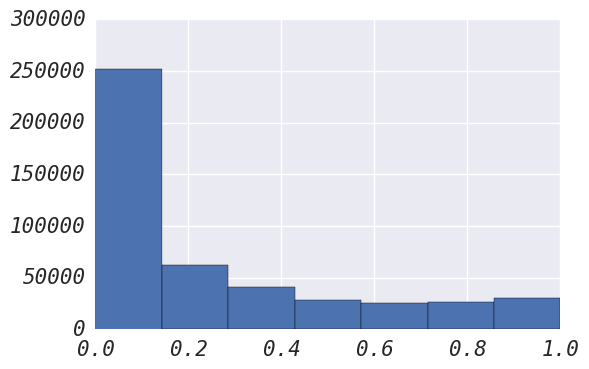

In [15]:
# distribution of scores in the dataset
_ = plt.hist(scores, bins=bins)

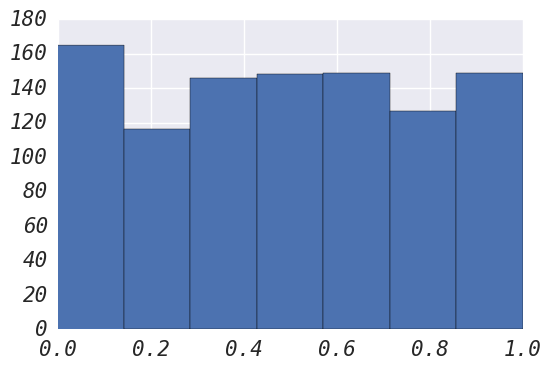

In [16]:
# Roughly equal selection across bins! This means we oversample from higher score regions.
# Note, we can change the shape of this distribution by specifying weight in the ml_sample 
# code.

# Note: If we want to calibrate our models to compute P(spam) we can also use this
# data as it draws a very smooth ROC curve.
_ = plt.hist(scores[sample_index], bins=bins)

### Simulate model assisted sampling 
This gives us error estimates associated with the sample

In [17]:
# Do some simulation to give us estimates for confidence intervals for Model Assisted Sampling
#   Take the sample 10k times, then look at the 2.5th and 97.5th percentile
#   this gives us a good approximation of the 95% confidence interval
ml_results = []

for _ in range(10000):
    sample_index, sample_weights = ml_sampler.biased_sample(
        biases=ml_sampler.interpolated_pdf_reciprocal(scores, bins=bins),  
        weights=views, 
        num_samples=1000
    )
    
    pcnt_positive_est = sample_weights[is_spam[sample_index]].sum() / views.sum() * 100.0
    
    ml_results.append(pcnt_positive_est)

In [18]:
# Do some simulation to give us estimates for confidence intervals for random sampling 
#(weighted by importance)
#   Take the sample 10k times, then look at the 2.5th and 97.5th percentile
#   this gives us a good approximation of the 95% confidence interval

rand_results = []

for _ in range(10000):

    sampled_ids = np.random.choice(len(views), 1000,
        p=views / views.sum(), replace=True)
    
    wrs_results = is_spam[sampled_ids]
    
    pcnt_positive_est = wrs_results.mean() * 100.0
    rand_results.append(pcnt_positive_est)

In [19]:
# ML sampling - the 95% Confidence Interval and estimated value of spam in the ecosystem.
ml_ci = np.percentile(ml_results, [2.5, 50, 97.5])

tutorial_helpers.print_confidence_interval(ml_ci)

Value: 1.6352
95% Confidence Interval: (1.1536, 2.2206)
	CI Width: 1.06703


In [20]:
# Random weighted sampling - the 95% Confidence Interval and estimated value of spam in the ecosystem.
rand_ci = np.percentile(rand_results, [2.5, 50, 97.5])

tutorial_helpers.print_confidence_interval(rand_ci)

Value: 1.6000
95% Confidence Interval: (0.9000, 2.5000)
	CI Width: 1.60000


In [21]:
# lets look at what we should expect from a typical confidence interval 
#   normal approximation, assumes weighted random sampling
def binomial_conf_width(p, n): 
    p = p / 100.0
    return np.array([
            p - 1.96 * np.sqrt(p * (1-p)/n), 
            p, 
            p + 1.96 * np.sqrt(p * (1-p)/n)]) * 100.0

In [22]:
binomial_ci = binomial_conf_width(pcnt_spam, 1000)

tutorial_helpers.print_confidence_interval(binomial_ci)

Value: 1.6497
95% Confidence Interval: (0.8602, 2.4391)
	CI Width: 1.57896


In [23]:
# For this example the confidence interval for the ML sampler is less than when 
#  using regular random sampling. 
# From above we also know that we get 2x more samples with ml_sampler (for this dataset)

# Note: np.ptp gives us the range of the confidence interval.
np.ptp(ml_ci) / np.ptp(rand_ci) - 1

-0.33310393490657286